In [172]:
import os
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torchvision import transforms
from torchvision.utils import save_image

In [173]:
#이 코드 파일이 존재하는 working directory에 mlp_img 폴더가 없으면, mlp_img 폴더 생성 
if not os.path.exists('./mlp_img'):
    os.mkdir('./mlp_img')

In [245]:
#input image 변환을 위한 함수
def to_img_latent(x):
    x = 0.5 * (x + 1)  
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 2, 1)
    return x

In [175]:
#output image 변환을 위한 함수
def to_img(x):
    x = 0.5 * (x + 1)  
    x = x.clamp(0, 1) 
    x = x.view(x.size(0), 1, 28, 28)
    return x

## 1. latent space dim = 20

#### MNIST data 받아오기 

In [176]:
from torch.utils.data import DataLoader  
from torchvision.datasets import MNIST  

In [594]:
num_epochs = 100 #training data 전체(여기서는 6만개)를 딱 한 번 사용했을 때, 한 epoch이 지나갔다고 말함 
batch_size = 128
learning_rate = 1e-3

img_transform = transforms.Compose([  #composes several transforms together  
    transforms.ToTensor(), #여기서는 PIL.Image.Image 를 tensor로 바꿔줌 
    transforms.Normalize((0.5,), (0.5,)) #channel 1이므로 각 1개의 element에 해당하는 mean / stdev 
])  


dataset = MNIST('./data', transform=img_transform, download  = True) #default 옵션은 train = True 
#Dataloader은 Iterator을 반환한다
#배치사이즈만큼 데이터를 로드해줌
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True) #여기에서 데이터를 꺼낼 때마다 transform적용됨 

In [595]:
print(dataset)  

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ./data
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5,), std=(0.5,))
                         )
    Target Transforms (if any): None


In [597]:
class autoencoder(nn.Module):
    def __init__(self):
        """
        생성자에서 2개의 nn.Sequential 모듈을 생성하고, 멤버변수(self.encoder, self.decoder)로 지정함.  
        """
        super(autoencoder, self).__init__() # 부모클래스(nn.Module)에서 정의된 메소드를 호출, 생성자 선언 
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.ReLU(True), #inplace = True 옵션 -> 또 다른 객체를 반환하지 않고 기존 객체를 수정, 메모리를 아주 조금 save 할 수 있다.    
            nn.Linear(256, 128),
            nn.ReLU(True), nn.Linear(128, 64), nn.ReLU(True), nn.Linear(64, 20)) #latent dimension = 2로 해야 visualization 할 수 있는 듯?
        self.decoder = nn.Sequential(
            nn.Linear(20, 64),
            nn.ReLU(True),  # ReLU를 쓰는 이유는 이게 generation이 아니라 classification이 목적이라서,, 데이터를 많이 버리는 게 좋음 
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True), nn.Linear(256, 28 * 28), nn.Tanh()) #마지막 layer에 tanh 안해주면 MSEloss 엄청 커짐.. 


    def forward(self, x):
        """
        순전파 함수에서는 입력 데이터의 Variable을 받아서 출력 데이터의 Variable을
        반환해야 함. Variable 상의 임의의 연산자뿐만 아니라 생성자에서 정의한
        모듈을 사용할 수 있음.
        """
        x_latent = self.encoder(x)
        x_output = self.decoder(x_latent)
        return x_latent, x_output 
    
    def decode(self, x_latent): #decode 함수를 여기서는 따로 지정해주었음  
        x_output = self.decoder(x_latent) 
        return x_output 


In [598]:
model = autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

#### Training AE using training data of MNIST

In [599]:
for epoch in range(num_epochs):#num_epochs  
    for data in dataloader:
        inputs, label = data #inputs.shape = [128,1,28,28], label = [128]
        inputs = inputs.view(inputs.size(0), -1)  #view는 size변경. inputs.size(0) = 128. 즉 inputs의 size를 [128,784]로 바꿔줌 
        inputs = Variable(inputs) # model에 넣어주려면 Variable로 싸줘야함 
        # ===================forward=====================
        latent, output = model(x = inputs) #autoencoder내에서 forward 진행됨
        #print(latent.shape)
        #print(output.shape)
        loss = criterion(output, inputs) #MSEloss
        # ===================backward====================
        optimizer.zero_grad()  #무슨기능? require_grad = True는 gradient 학습시키는 학
        loss.backward()  #무슨기능?   
        optimizer.step() #무슨기능?   
    # ===================log========================  
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, loss.data))
    # ===============Latent Space와, Output 의 결과값 그림으로 저장 ===============
    if epoch % 10 == 0: #10epoch 지날 때마다 latent space에서의 이미지랑, output의 이미지를 보여줌 
        # ----------latent의 이미지 보여주기 ------------
        #print(latent.shape) # 여기서 96개가 남는 이유는 마지막 interation에서 60000 - 128*n 하면 남는 나머지
        #pic = to_img_latent(latent.data)  #to_img_latent 
        #save_image(pic, './mlp_img/latent_{}.png'.format(epoch))  
        
        #-----------output의 이미지 보여주기 -------------
        #print(output.shape)
        pic = to_img(output.data) #to_img 
        save_image(pic, './mlp_img/output_{}.png'.format(epoch))  

torch.save(model.state_dict(), './sim_autoencoder.pth')  

epoch [1/100], loss:0.1539
epoch [2/100], loss:0.1087
epoch [3/100], loss:0.0884
epoch [4/100], loss:0.0855
epoch [5/100], loss:0.0809
epoch [6/100], loss:0.0723
epoch [7/100], loss:0.0818
epoch [8/100], loss:0.0724
epoch [9/100], loss:0.0629
epoch [10/100], loss:0.0630
epoch [11/100], loss:0.0648
epoch [12/100], loss:0.0594
epoch [13/100], loss:0.0546
epoch [14/100], loss:0.0555
epoch [15/100], loss:0.0520
epoch [16/100], loss:0.0540
epoch [17/100], loss:0.0578
epoch [18/100], loss:0.0569
epoch [19/100], loss:0.0532
epoch [20/100], loss:0.0527
epoch [21/100], loss:0.0468
epoch [22/100], loss:0.0463
epoch [23/100], loss:0.0455
epoch [24/100], loss:0.0439
epoch [25/100], loss:0.0441
epoch [26/100], loss:0.0477
epoch [27/100], loss:0.0483
epoch [28/100], loss:0.0459
epoch [29/100], loss:0.0474
epoch [30/100], loss:0.0454
epoch [31/100], loss:0.0420
epoch [32/100], loss:0.0415
epoch [33/100], loss:0.0461
epoch [34/100], loss:0.0435
epoch [35/100], loss:0.0391
epoch [36/100], loss:0.0374
e

#### Test using MNIST 
- 앞에서 training한 모델에 test input 넣고 forward propagation  
- show output & show latent space  

In [601]:
test_dataset = MNIST('./data', train = False, transform=img_transform, download  = True) #default 옵션은 train = True 
dataloader = DataLoader(test_dataset, batch_size = 10000, shuffle=True)  

In [602]:
print(test_dataset)  

Dataset MNIST
    Number of datapoints: 10000
    Split: test
    Root Location: ./data
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5,), std=(0.5,))
                         )
    Target Transforms (if any): None


#### test data를 가지고, 앞에서 만들어진 AE에 forward 진행

In [603]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [604]:
for i in range(1): #test data에 대해서 한번만 실행 
    for data in dataloader: #batch_size = 10000 
        test_inputs, label = data
        test_inputs = test_inputs.view(test_inputs.size(0), -1)
        test_inputs = Variable(test_inputs)
        # ========= forward =========
        latent, output = model(test_inputs)
        print(latent)
        loss = criterion(output, test_inputs)
        print('test_loss(MSE) :{:.4f}'.format(loss.data))

tensor([[  1.6045,   4.0377,  -2.9868,  ...,  -2.1308,  -1.9360,  -4.7985],
        [  2.0229,  -6.0450,   2.0784,  ...,   2.7435, -13.9025,  -1.5440],
        [ -4.7561,  -1.2825,   2.5874,  ...,   1.1388, -19.0727,   3.9645],
        ...,
        [ -5.4704,  -2.9263,  -9.0188,  ...,  -5.6127, -17.1510,  -3.7378],
        [  1.7831,   6.0204,   1.6571,  ...,   1.9207, -11.8628,   5.0762],
        [  7.0378,  -1.1580,  -7.7430,  ...,  -8.6076, -16.0113,  -6.3838]],
       grad_fn=<AddmmBackward>)
test_loss(MSE) :0.0316


In [605]:
print(latent.shape)
print(label.shape) #원래 데이터에 대한 label
print(output.shape) #AE를 거친 output 
#print(output[10]) #10번째 데이터 어떻게 생겼는지
print(output[2000].shape)  

torch.Size([10000, 20])
torch.Size([10000])
torch.Size([10000, 784])
torch.Size([784])


In [606]:
#이 두개를 비교해서 matplotlib에 찍어줘야 함
print(test_inputs.shape)  
print(output.shape)  

torch.Size([10000, 784])
torch.Size([10000, 784])


#### Task1. matplotlib 이용해서 실제 데이터와 모델 output 데이터(reconstruction)를 찍어주자!
- test data에 대해서 찍었음  
- 정답(test_inputs)/output/정답(test_inputs)/output -> 번갈아가면서 찍힘  

In [607]:
temp = np.array(test_inputs[0]) #tensor를 array로 바꾸어줘야 matplotlib로 그릴 수 있음  
temp = np.reshape(temp, (28, 28)) # (784,)를 (28,28)로 만들어줌 

In [608]:
#tensor를 array로 바꾸어줘야 matplotlib로 그릴 수 있음  
# (784,)를 (28,28)로 만들어줌 
test_np = np.array(test_inputs) 
test_np.shape
output_np = output.detach().numpy()
output_np.shape

(10000, 784)

In [609]:
output_np[0].shape

(784,)

In [610]:
import scipy
from scipy.stats import norm

In [611]:
#------------이제 test_np랑 output_np를 쓰면 됩니다. ------------
n = 20 
digit_size = 28 #픽셀단위?
figure = np.zeros((digit_size*n, digit_size*n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

In [612]:
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):  
        if j % 2 == 0: 
            test_tmp = np.array(test_np[int(j/2)])  
            test_tmp = np.reshape(test_tmp, (28, 28))  #실제 데이터
            figure[(i*digit_size):((i + 1) * digit_size), (j*digit_size): ((j+1)*digit_size)] = test_tmp  
        else:
            out_tmp = np.array(output_np[int(j/2)]) 
            out_tmp = np.reshape(out_tmp, (28, 28)) #모델의 output 데이터 
            figure[(i*digit_size):((i + 1) * digit_size), (j*digit_size): ((j+1)*digit_size)] = out_tmp  


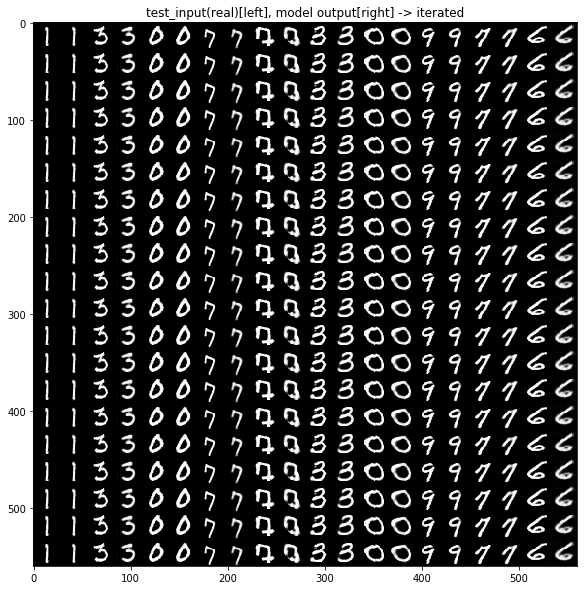

In [613]:
plt.figure(figsize = (10,10))  
plt.title('test_input(real)[left], model output[right] -> iterated')  
plt.imshow(figure, cmap = 'gray')  
plt.show()  

#### Task2. matplotlib 사용해서 latent space를 visualization 하자!
- 여기서는 latent space를 2-dimension으로 해서 해야함! 
- test data 를 이용함 

#### a. PCA를 이용하여 2개의 dimension을 선택 (위 latent dimension = 20 을 이용)  하여 그 2차원 좌표 상에 데이터를 표현함  

In [614]:
from sklearn.decomposition import PCA  

In [627]:
pca = PCA(n_components = 2)  
latent_np = latent.detach().numpy()
pca_output = pca.fit_transform(latent_np)   

In [628]:
type(pca_output)  

numpy.ndarray

(10000, 2)
(10000, 784)


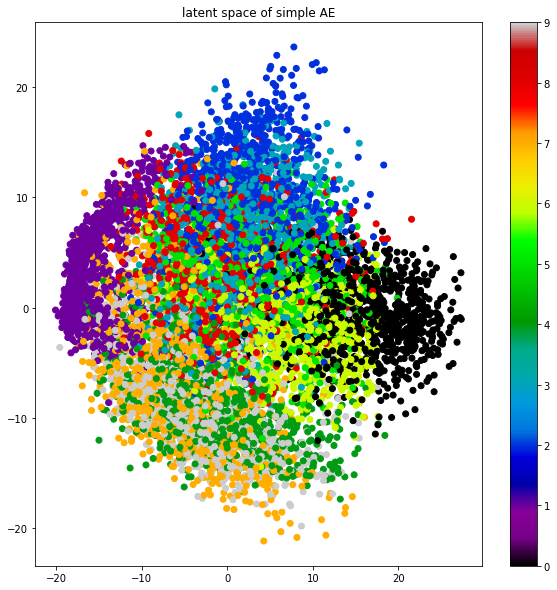

In [629]:
# test 데이터를 forward propagation 했을 때 latent space를 visualization 하자
output_np = output.detach().numpy()   
print(pca_output.shape) 
print(output_np.shape) 
plt.figure(figsize = (10,10))   
plt.scatter(pca_output[:,0], pca_output[:,1], c = label, cmap = 'nipy_spectral') # latent space의 feature 수를 2로 줄여야 하는지 
plt.clim(0,9) 
plt.colorbar()  
plt.title('latent space of simple AE')  
plt.show() 

#### Task3. 20 dimension에 대한 좌표값 구간 내에서 uiform sampling 후, decoder 단을 통과한 output그림을 matplotlib로 표현
- PCA단에서 latent space를 표현할 때는 dim= 2로 해서 했을지라도, 네트워크 구조상 decoder 통과시키려면 20개 dim에 대해 random sampling 해야함 

#### 이 부분은 무시해주세요 ㅠ

In [632]:
from torch.distributions import uniform  
#range를 위에 그림에 맞게 해서 다시 sampling 하기 ! 지금 0~1사이에서만 sampling되어서 밑에 그림이 이상하게 나온 것  
z_grid = torch.empty(400, 20).uniform_(-25, 30)  
z_grid.shape  

torch.Size([400, 20])

In [633]:
print(pca_output[:,0].max()) #여기서 latent가 아니라 PCA를 이용해서 뱉어낸 output array의 이름이 될 것임! 
print(pca_output[:,0].min())
print(pca_output[:,1].max())
print(pca_output[:,1].min())

27.3747
-20.0865
23.625
-21.1698


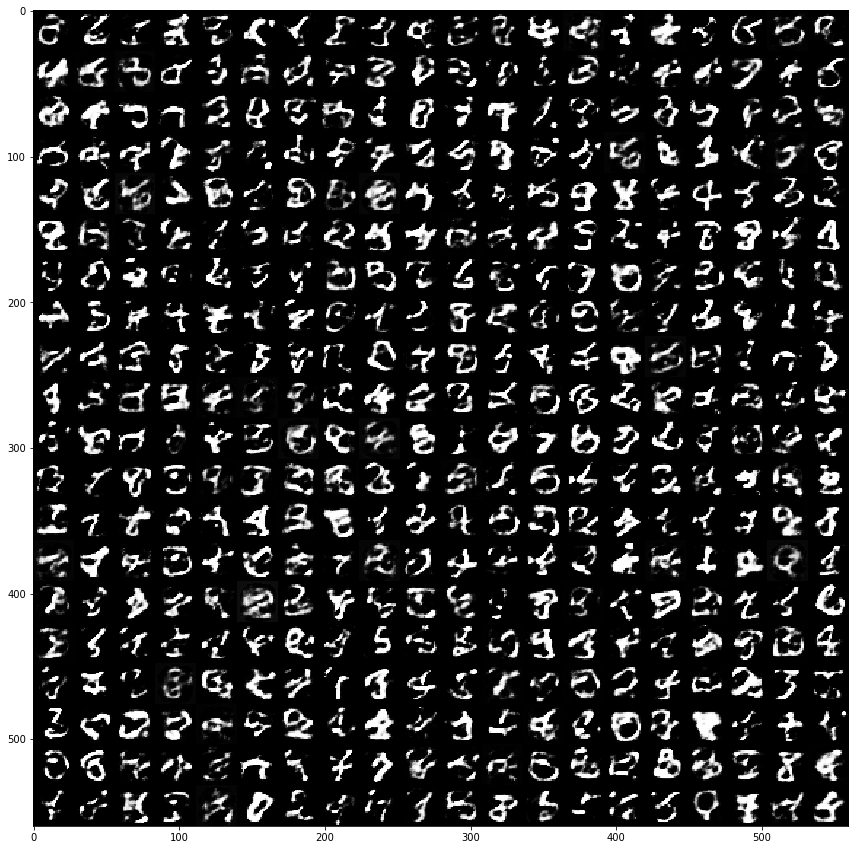

In [635]:
grid_out = model.decode(z_grid)   
grid_out.shape    
grid_out = grid_out.reshape(n, n, digit_size, digit_size)   
grid_out.shape   

plt.figure(figsize=(15,15))   
plt.imshow(np.block(list(map(list, grid_out.detach().numpy()))), cmap='gray')   
plt.show()   

## 2. latent space dim = 2

In [636]:
num_epochs = 100 #training data 전체(여기서는 6만개)를 딱 한 번 사용했을 때, 한 epoch이 지나갔다고 말함 
batch_size = 128
learning_rate = 1e-3

dataset = MNIST('./data', transform=img_transform, download  = True) #default 옵션은 train = True 
#Dataloader은 Iterator을 반환한다
#배치사이즈만큼 데이터를 로드해줌
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)  

In [637]:
class autoencoder(nn.Module):
    def __init__(self):
        """
        생성자에서 2개의 nn.Sequential 모듈을 생성하고, 멤버변수(self.encoder, self.decoder)로 지정함.  
        """
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True), #inplace = True 옵션 -> 또 다른 객체를 반환하지 않고 기존 객체를 수정, 메모리를 아주 조금 save 할 수 있다.    
            nn.Linear(128, 64),
            nn.ReLU(True), nn.Linear(64, 12), nn.ReLU(True), nn.Linear(12, 2)) #latent dimension = 2로 해야 visualization 할 수 있는 듯?
        self.decoder = nn.Sequential(  
            nn.Linear(2, 12),
            nn.ReLU(True),  # ReLU를 쓰는 이유는 이게 generation이 아니라 classification이 목적이라서,, 데이터를 많이 버리는 게 좋음 
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True), nn.Linear(128, 28 * 28), nn.Tanh()) #마지막 layer에 tanh 안해주면 MSEloss 엄청 커짐.. 

    def forward(self, x):
        """
        순전파 함수에서는 입력 데이터의 Variable을 받아서 출력 데이터의 Variable을
        반환해야 함. Variable 상의 임의의 연산자뿐만 아니라 생성자에서 정의한
        모듈을 사용할 수 있음.
        """
        x_latent = self.encoder(x)
        x_output = self.decoder(x_latent)
        return x_latent, x_output  
    
    def decode(self, x_latent): #decode 함수를 여기서는 따로 지정해주었음 
        x_output = self.decoder(x_latent)
        return x_output


In [638]:
model2 = autoencoder()
criterion2 = nn.MSELoss()  
optimizer2 = torch.optim.Adam(model2.parameters(), lr = learning_rate, weight_decay = 1e-5)   

#### training 하기 

In [639]:
for epoch in range(num_epochs):#num_epochs
    for data in dataloader:
        inputs, label = data
        inputs = inputs.view(inputs.size(0),-1)
        inputs = Variable(inputs)
        #forward
        latent, output = model2(x = inputs)
        # backward
        loss = criterion2(output, inputs)  
        optimizer2.zero_grad()
        loss.backward() 
        optimizer2.step() 
    print("epoch [{}/{}], loss:{:.4f}".format(epoch+1, num_epochs, loss.data))    

epoch [1/100], loss:0.2014
epoch [2/100], loss:0.1838
epoch [3/100], loss:0.1734
epoch [4/100], loss:0.1840
epoch [5/100], loss:0.1991
epoch [6/100], loss:0.1745
epoch [7/100], loss:0.1819
epoch [8/100], loss:0.1584
epoch [9/100], loss:0.1576
epoch [10/100], loss:0.1730
epoch [11/100], loss:0.1543
epoch [12/100], loss:0.1615
epoch [13/100], loss:0.1569
epoch [14/100], loss:0.1375
epoch [15/100], loss:0.1618
epoch [16/100], loss:0.1679
epoch [17/100], loss:0.1672
epoch [18/100], loss:0.1774
epoch [19/100], loss:0.1673
epoch [20/100], loss:0.1508
epoch [21/100], loss:0.1508
epoch [22/100], loss:0.1534
epoch [23/100], loss:0.1460
epoch [24/100], loss:0.1522
epoch [25/100], loss:0.1527
epoch [26/100], loss:0.1513
epoch [27/100], loss:0.1565
epoch [28/100], loss:0.1557
epoch [29/100], loss:0.1493
epoch [30/100], loss:0.1486
epoch [31/100], loss:0.1704
epoch [32/100], loss:0.1507
epoch [33/100], loss:0.1411
epoch [34/100], loss:0.1578
epoch [35/100], loss:0.1578
epoch [36/100], loss:0.1512
e

In [640]:
print(output.shape) #마지막 배치에서 데이터 개수가 이렇게 되어서 그렇다  

torch.Size([96, 784])


#### test 하기

In [641]:
test_dataset = MNIST('./data', train = False, transform = img_transform, download = True)
dataloader = DataLoader(test_dataset, batch_size = 10000, shuffle = True)   

In [642]:
for i in range(1):
    for data in dataloader:
        test_inputs, label = data
        test_inputs = test_inputs.view(test_inputs.size(0), -1)
        test_inputs = Variable(test_inputs)
        latent, output = model2(x = test_inputs)
        loss = criterion(output, test_inputs)
        print('test_loss(MSE): {:.4f}'.format(loss.data)) 

test_loss(MSE): 0.1468


#### latent space 

(10000, 2)
(10000, 784)


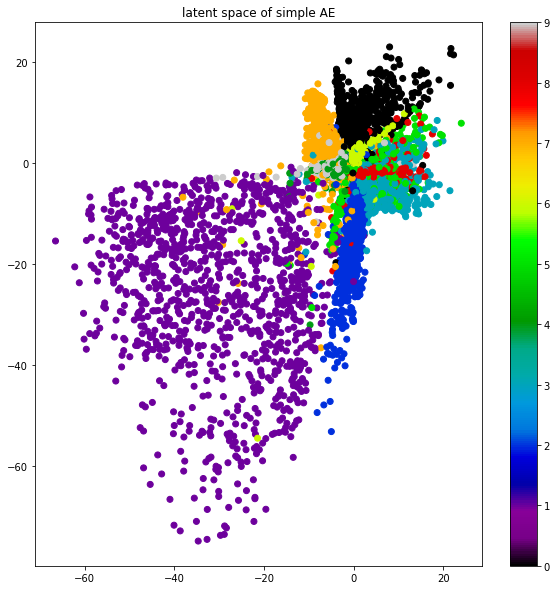

In [643]:
# test 데이터를 forward propagation 했을 때 latent space를 visualization 하자
latent_np = latent.detach().numpy()  
output_np = output.detach().numpy()  
print(latent_np.shape)
print(output_np.shape)
plt.figure(figsize = (10,10))  
plt.scatter(latent_np[:,0], latent_np[:,1], c = label, cmap = 'nipy_spectral') # latent space의 feature 수를 2로 줄여야 하는지 
plt.clim(0,9) 
plt.colorbar() 
plt.title('latent space of simple AE')  
plt.show() 

####  위 그림에서 등간격으로 sampling해서(uniform하게?) -> decoder 통과시켜서, latent space 상에서 한 것과 비교하기!! 

- uniform 하게 sampling 해서 통과시킨 것과, 위에서 latent space 상에 표현해 준 것이 비슷하게 나와야 함  
- 한 이미지당 dimension = 2인 것을 랜덤 샘플링 해서, 그것을 decoder단에 통과시킴   
- 한 변에 총 20개의 이미지를 표현해 줄 예정  

In [644]:
from torch.distributions import uniform  

In [773]:
#range를 위에 그림에 맞게 해서 다시 sampling 하기 ! 지금 0~1사이에서만 sampling되어서 밑에 그림이 이상하게 나온 것  

In [779]:
n = 20
digit_size = 28
z_grid = torch.empty(n*n, 2) 
z_grid.shape

x_len = latent[:,0].max() - latent[:,0].min()  
x_section_len = float(x_len / n) #이 구간 길이에서 20개 sampling   
y_len = latent[:,1].max() - latent[:,1].min() 
y_section_len = float(y_len / n)  

z_grid = torch.empty(n*n,2) 
#등간격 샘플링
for i in range(n): 
    for j in range(n):  
        z_grid[(i*n + j), 0] = torch.empty(1,).uniform_(float(latent[:,0].min()) + i*x_section_len, float(latent[:,0].min()) + (i+1)*x_section_len) #i행의 x값
        z_grid[(i*n + j), 1] = torch.empty(1,).uniform_(float(latent[:,1].max()) - j*y_section_len, float(latent[:,1].max()) - (j+1)*y_section_len) #j행의 y값   

In [780]:
print(latent[:,0].max())  
print(latent[:,0].min())
print(latent[:,1].max())
print(latent[:,1].min())
print()
print(x_section_len)
print(y_section_len)
print()
print(z_grid[:,0].max())
print(z_grid[:,0].min())
print(z_grid[:,1].max())
print(z_grid[:,1].min()) 
print()
print(z_grid[0]) 

tensor(24.0691, grad_fn=<MaxBackward1>)
tensor(-66.5601, grad_fn=<MinBackward1>)
tensor(23.0515, grad_fn=<MaxBackward1>)
tensor(-74.8131, grad_fn=<MinBackward1>)

4.531458854675293
4.89323091506958

tensor(23.9214)
tensor(-66.3019)
tensor(22.7918)
tensor(-74.7357)

tensor([-64.4261,  21.2524])


In [781]:
grid_out = model2.decode(z_grid)  
grid_out.shape  
grid_out = grid_out.reshape(n, n, digit_size, digit_size)  
grid_out.shape  

torch.Size([20, 20, 28, 28])

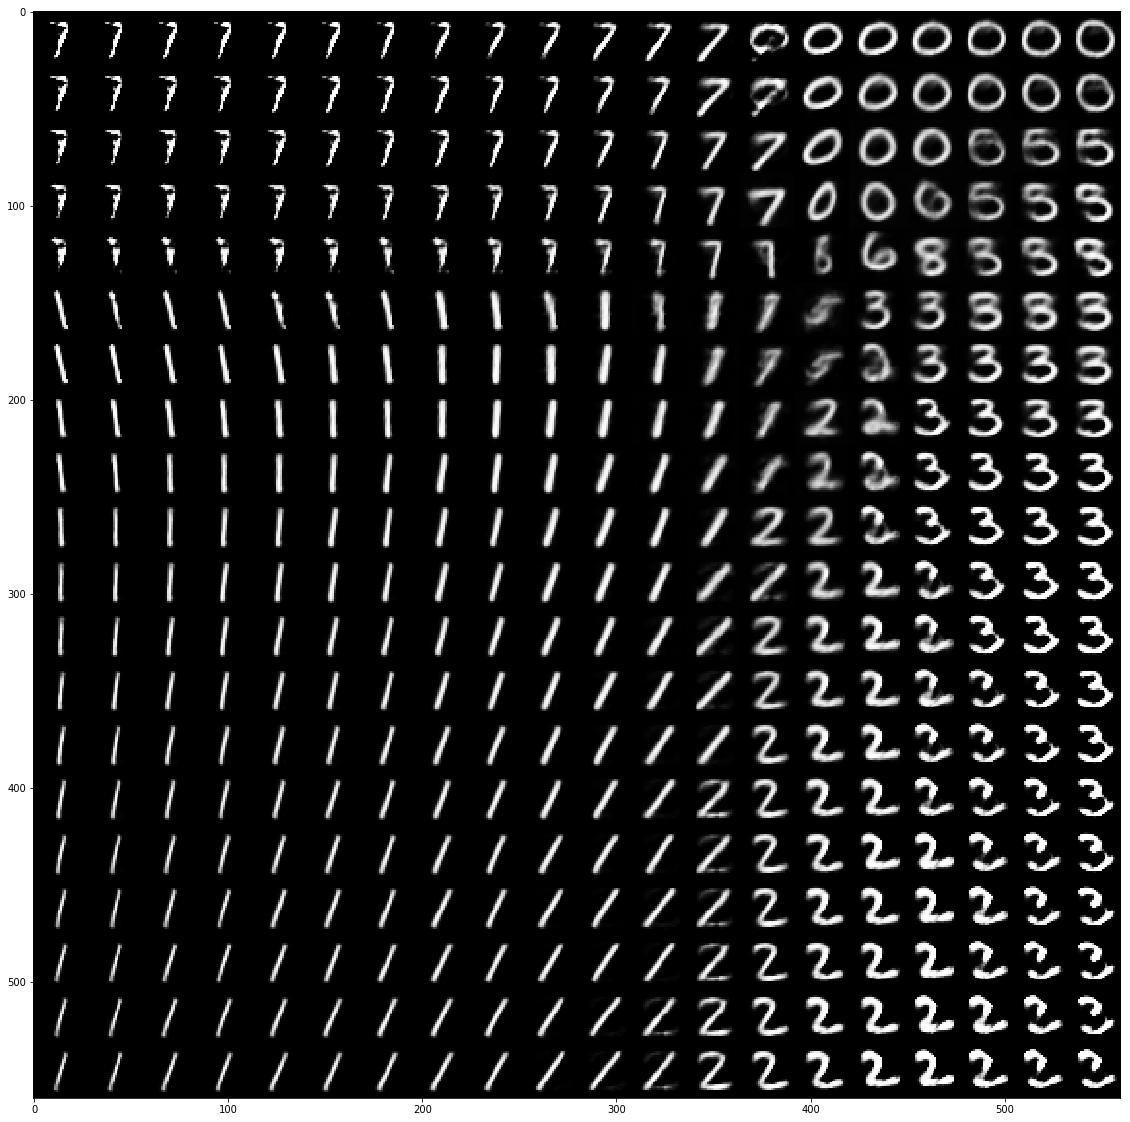

In [783]:
## for문으로 다시 짜기  
figure = np.zeros((digit_size*n, digit_size*n))

for i in range(n):  
    for j in range(n):  
        temp = grid_out[i,j]  
        temp = temp.detach().numpy()  
        figure[j*digit_size:(j+1)*(digit_size), i*digit_size:(i+1)*digit_size] = temp  

plt.figure(figsize=(20,20))    
plt.imshow(figure, cmap='gray')  
plt.show()    